## Gdrive and other

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import cv2

# Data

In [52]:
from tqdm import tqdm

In [84]:
dirname_clean = '/Users/nikitaazhazha/Downloads/train 3'

x_clean, y_clean = [], []

for fname in tqdm(os.listdir(dirname_clean)):
    img = cv2.imread(os.path.join(dirname_clean, fname), cv2.IMREAD_GRAYSCALE)
    y_clean.append(int(fname.split('label')[1].split('.jpg')[0]))

    h, w = img.shape
    size = min(h, w)
    h0 = int((h - size) / 2)
    w0 = int((w - size) / 2)

    img = img[h0: h0 + size, w0: w0 + size]
    img = cv2.resize(img, (320, 320), interpolation=cv2.INTER_AREA)

    x_clean.append(img)

len(x_clean), len(y_clean)

100%|██████████| 621/621 [00:00<00:00, 3082.61it/s]


(621, 621)

# Albumentations

In [23]:
import random
import albumentations as A

from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

In [48]:
def get_aug(images, labels):
    Aug = []
    Aug_ans = []

    for (a, b) in zip(images, labels):
        Aug.append(a)
        Aug_ans.append(b)

        transform = A.HorizontalFlip(p=1)

        flip_img = transform(image=a)['image']

        Aug.append(flip_img)
        Aug_ans.append(b)

        transform = A.GaussNoise(var_limit=(10, 250), p=1)
        Aug.append(transform(image=a)['image'])
        Aug_ans.append(b)

        Aug.append(transform(image=flip_img)['image'])
        Aug_ans.append(b)

        transform = A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.4, p=1)
        Aug.append(transform(image=a)['image'])
        Aug_ans.append(b)

        transform = A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=1)
        Aug.append(transform(image=a)['image'])
        Aug_ans.append(b)

        transform = A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1)
        Aug.append(transform(image=a)['image'])
        Aug_ans.append(b)

        Aug.append(transform(image=flip_img)['image'])
        Aug_ans.append(b)

        angle = np.arange(-10, 11, 1)
        angle0 = random.choice(angle)

        shift = 0.01 * np.arange(-10, 11, 1)
        shift0 = random.choice(shift)

        transform = A.ShiftScaleRotate(shift_limit=float(shift0), rotate_limit=float(angle0), scale_limit=0, p=1)

        augmented_image = transform(image=a)['image']

        Aug.append(transform(image=augmented_image)['image'])
        Aug_ans.append(b)

    print(f'uploaded: {len(images)} processed: {len(Aug)}')

    return Aug, Aug_ans

In [85]:
trainAug, trainAug_ans = get_aug(x_clean, y_clean)

uploaded: 621 processed: 5589


# Show Aug

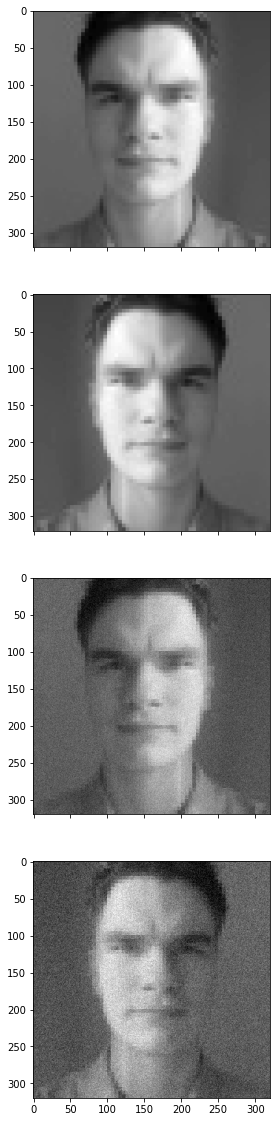

In [86]:
fig, ax = plt.subplots(4, figsize=(20, 20), sharex=True, sharey=True)

for i in range(4):
    ax[i].imshow(trainAug[i], cmap=plt.cm.gray)

# Haar

In [7]:
def DoHaar(imgs, labels):
    x, y = [], []

    x_fails, y_fails = [], []

    haarcascade_te = [
        'haarcascade_frontalface_alt_tree.xml',
        'haarcascade_frontalface_alt.xml',
        'haarcascade_frontalface_alt2.xml',
        'haarcascade_frontalface_default.xml',
    ]

    i = 0

    for img in tqdm(imgs):
        for haar_te in haarcascade_te:

            face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + haar_te)
            face = face_cascade.detectMultiScale(img)

            if len(face):
                break

        for (a, b, w, h) in face:
            cv2.rectangle(img, (a, b), (a + w, b + h), (0, 0, 255), 2)
            face = img[b:b + h, a:a + w]

        try:
            h, w = face.shape
            size = min(h, w)
            h0 = int((h - size) / 2)
            w0 = int((w - size) / 2)

            img = face[h0: h0 + size, w0: w0 + size]
            img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_AREA)

            x.append(img)
            y.append(labels[i])
        except:
            x_fails.append(img)
            y_fails.append(labels[i])
        i += 1

    print(f'uploaded: {len(imgs)} processed: {len(x)}, fails: {len(x_fails)}')

    return x, y, x_fails, y_fails

In [55]:
x, y, x_fails, y_fails = DoHaar(trainAug, trainAug_ans)

100%|██████████| 5589/5589 [20:23<00:00,  4.57it/s] 

uploaded: 5589 processed: 5202, fails: 387


# Show Haar

Corpped Haar

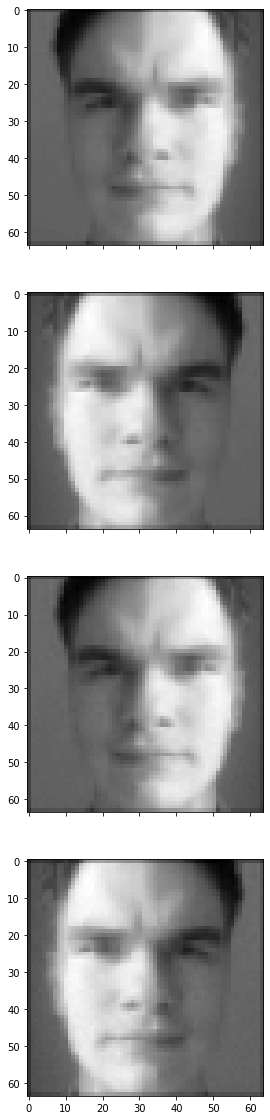

In [13]:
fig, ax = plt.subplots(4, figsize=(20, 20), sharex=True, sharey=True)

for i in range(4):
    ax[i].imshow(x[i], cmap=plt.cm.gray)

Haar Fails

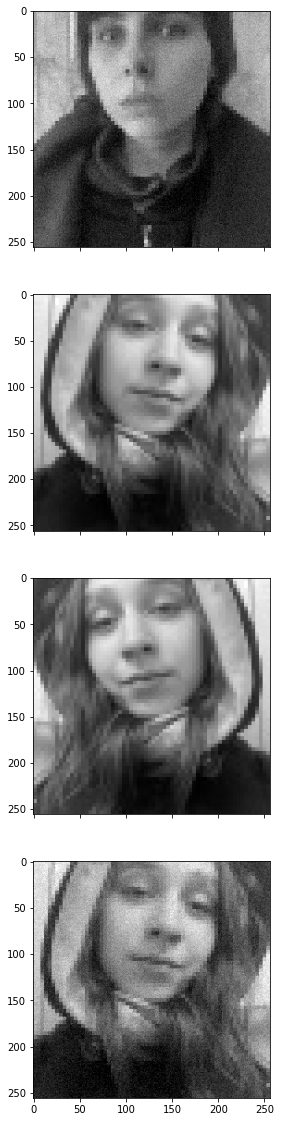

In [9]:
fig, ax = plt.subplots(4, figsize=(20, 20), sharex=True, sharey=True)

for i in range(4):
    ax[i].imshow(x_fails[i], cmap=plt.cm.gray)

  6%|▌         | 45/742 [00:00<00:09, 72.16it/s] 


ValueError: num must be 1 <= num <= 45, not 46

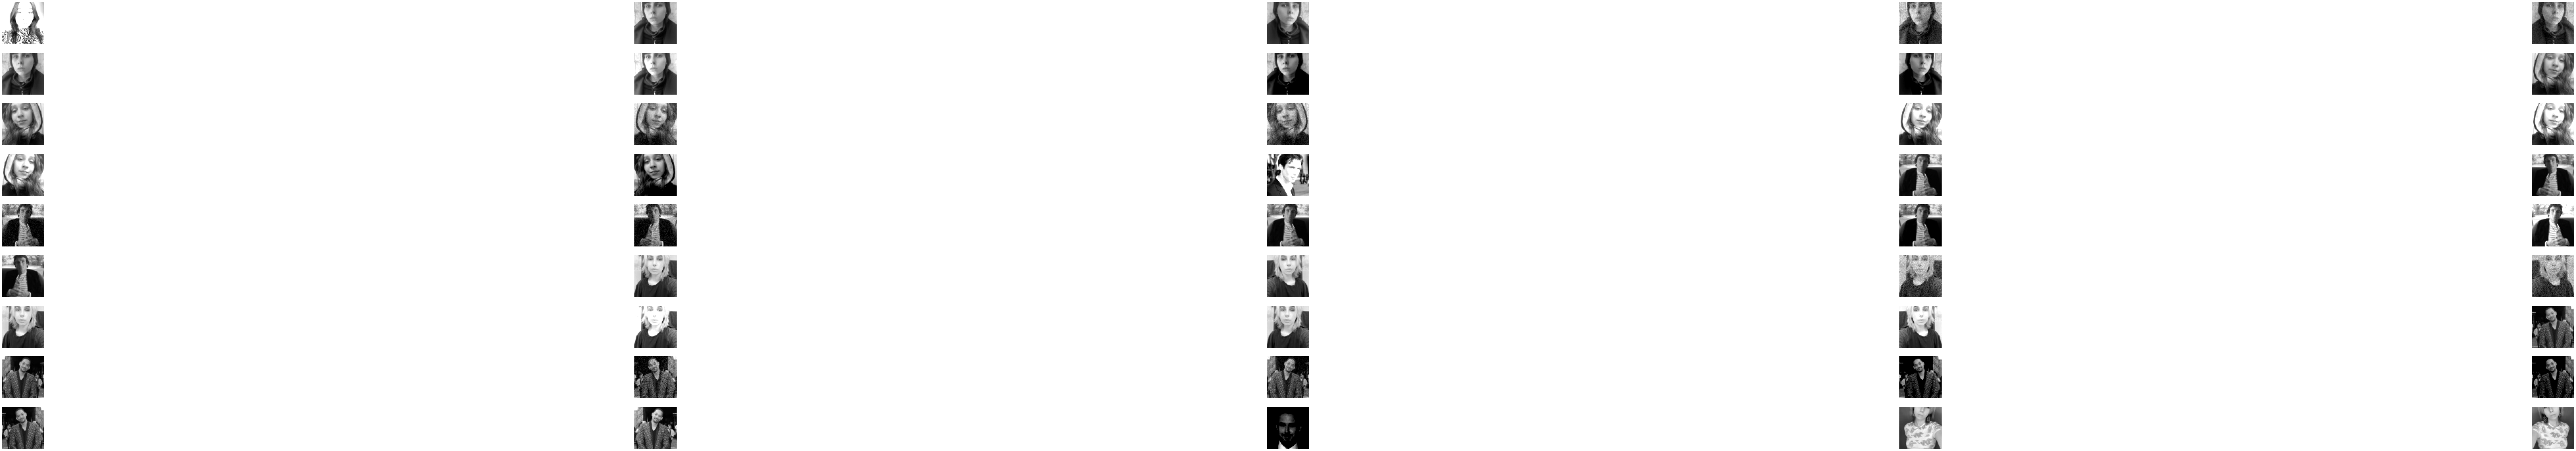

In [125]:
pic_box = plt.figure(figsize=(200, 30))

for i in tqdm(range(len(x_fails))):
    image = x_fails[i]
    pic_box.add_subplot(9, 5, i + 1)
    plt.imshow(image, cmap=plt.cm.gray)
    plt.axis('off')

plt.show()

# Dlib

In [10]:
import dlib
from PIL import Image

In [11]:
def DoDlib(imgs, labels):
    dirmane = '/Users/nikitaazhazha/Downloads/mmod_human_face_detector.dat'

    face_detector = dlib.cnn_face_detection_model_v1(dirmane)
    # face_detector = dlib.get_frontal_face_detector()

    crop_width = 64

    x_dlib, y_dlib = [], []

    x_fails_dlib, y_fails_dlib = [], []

    i = 0

    for img in tqdm(imgs):
        img_def = img
        detected_faces = face_detector(img, 1)
        if len(detected_faces) == 1:
            for face_rect in detected_faces:
                image_to_crop = Image.fromarray(img)

                crop_area = (
                    face_rect.rect.left(), face_rect.rect.top(), face_rect.rect.right(), face_rect.rect.bottom())

                cropped_image = image_to_crop.crop(crop_area)
                crop_size = (crop_width, crop_width)
                cropped_image.thumbnail(crop_size)
                x_dlib.append(cropped_image)
                y_dlib.append(labels[i])
        else:
            x_fails_dlib.append(img_def)
            y_fails_dlib.append(labels[i])
        i += 1

    print(f'uploaded: {len(imgs)} processed: {len(x_dlib)}, fails: {len(x_fails_dlib)}')

    return x_dlib, y_dlib, x_fails_dlib, y_fails_dlib

In [87]:
x_dlib, y_dlib, x_fails_dlib, y_fails_dlib = DoDlib(trainAug, trainAug_ans)

100%|██████████| 5589/5589 [49:35<00:00,  1.88it/s] 

uploaded: 5589 processed: 5440, fails: 149


In [88]:
x_dlib_np = []
for img in tqdm(x_dlib):
    x_dlib_np.append(np.asarray(img))

100%|██████████| 5440/5440 [00:00<00:00, 40459.64it/s]


In [58]:
x_fails_dlib_np = []
for img in tqdm(x_fails_dlib):
    x_fails_dlib_np.append(np.asarray(img))

100%|██████████| 64/64 [00:00<00:00, 997901.32it/s]


In [59]:
x_dlib_after = x + x_dlib_np
y_dlib_after = y + y_dlib

len(x_dlib_after), len(y_dlib_after)

(5525, 5525)

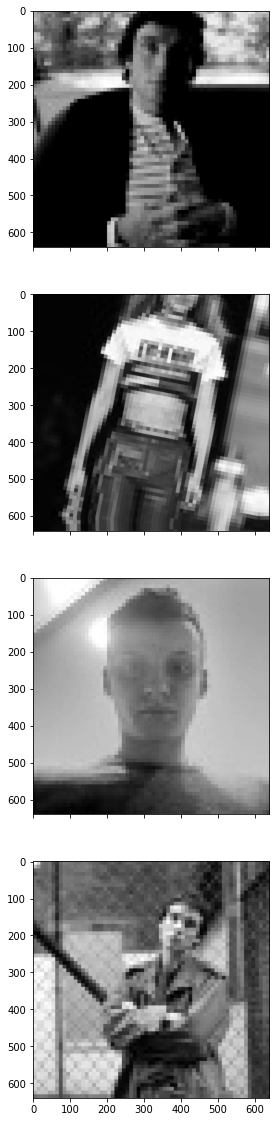

In [60]:
fig, ax = plt.subplots(4, figsize=(20, 20), sharex=True, sharey=True)

for i in range(4):
    ax[i].imshow(x_fails_dlib_np[i], cmap=plt.cm.gray)

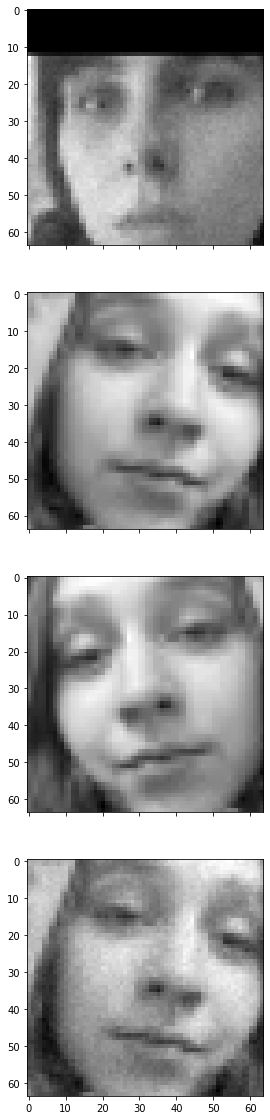

In [17]:
fig, ax = plt.subplots(4, figsize=(20, 20), sharex=True, sharey=True)

for i in range(4):
    ax[i].imshow(x_dlib[i], cmap=plt.cm.gray)

 # Hog

In [18]:
from skimage.feature import hog
from skimage import exposure

In [19]:
def HogImgs(images):
    winSize = (64, 64)
    blockSize = (16, 16)
    blockStride = (8, 8)
    cellSize = (8, 8)
    nbins = 9

    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)

    winStride = (8, 8)
    padding = (8, 8)
    locations = ((0, 0),)

    hog_images = []

    for img in tqdm(images):
        face_hist = hog.compute(img, winStride, padding, locations)
        hog_images.append((face_hist, 1))

    return hog_images

Hog for Haar + Dlib

In [110]:
train_hog_haar = HogImgs(x)
print(len(train_hog_haar))

100%|██████████| 5202/5202 [00:00<00:00, 12038.32it/s]

5202


Hog for Dlib

In [111]:
train_hog_dlib = HogImgs(x_dlib_np)
print(len(train_hog_haar))

100%|██████████| 5440/5440 [00:00<00:00, 12402.96it/s]

5202


Hog for fails

In [112]:
train_hog_fails = HogImgs(trainAug)
print(len(train_hog_fails))

100%|██████████| 5589/5589 [00:02<00:00, 1863.81it/s]


5589


# Show HOG

In [112]:
fd, hog_image = hog(x_clean[0], orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True)

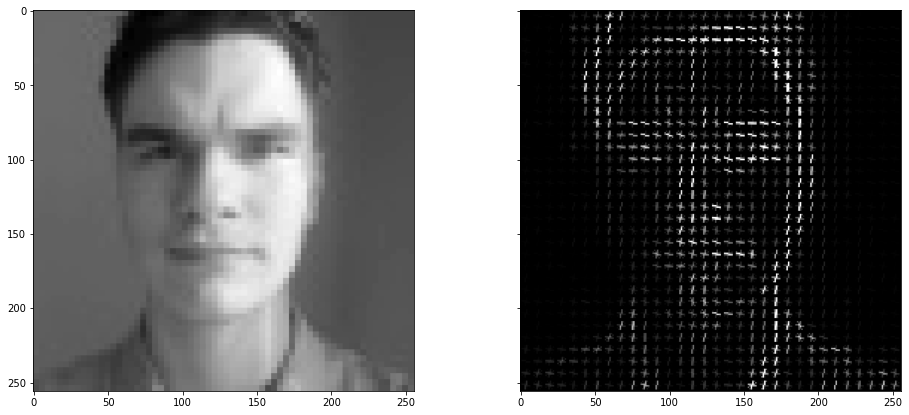

In [113]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), sharex=True, sharey=True)

ax1.imshow(x_clean[0], cmap=plt.cm.gray)

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)

plt.show()

# Training

 Find parameters for SMV for Haar

In [24]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

 Find parameters for SMV for Haar

In [140]:
x_test_haar = np.asarray([i[0] for i in train_hog_haar])

parameters_haar = {'gamma': [i for i in np.arange(0.01, 0.05, 0.001)]}
svc_haar = svm.SVC(kernel='rbf', C=20)
clf_haar = GridSearchCV(svc_haar, parameters_haar)
clf_haar.fit(x_test_haar, trainAug_ans)
print(clf_haar.best_estimator_)

SVC(gamma=0.042999999999999976)
SVC(C=20, gamma=0.04899999999999997)


SVC(C=50, gamma=0.01), SVC(C=25, gamma=0.05), SVC(C=20, gamma=0.04), SVC(C=20, SVC(gamma=0.042999999999999976), gamma=0.04899999999999997)

 Find parameters for SMV for Fails

In [141]:
x_test_fails = np.asarray([i[0] for i in train_hog_fails])

parameters_fails = {'gamma': [i for i in np.arange(0.01, 0.05, 0.001)]}
svc_fails = svm.SVC(kernel='rbf', C=3)
clf_fails = GridSearchCV(svc_fails, parameters_fails)
clf_fails.fit(x_test_fails, y_fails)
print(clf_fails.best_estimator_)

SVC(C=3, gamma=0.03999999999999997)


SVC(C=10, gamma=0.01), SVC(C=5, gamma=0.05), SVC(C=3, gamma=0.04), SVC(C=3, gamma=0.03999999999999997)

In [104]:
from sklearn.svm import SVC

SVM for Haar

In [114]:
x_test_haar = np.asarray([i[0] for i in train_hog_haar])

model_svm_haar = SVC(kernel='rbf', C=20, gamma=0.04899999999999997)
model_svm_haar.fit(x_test_haar, y)

SVC(C=20, gamma=0.04899999999999997)

SVM for DLib

In [115]:
x_test_dlib = np.asarray([i[0] for i in train_hog_dlib])

model_svm_dlib = SVC(kernel='rbf', C=20, gamma=0.04899999999999997)
model_svm_dlib.fit(x_test_dlib, y_dlib)

SVC(C=20, gamma=0.04899999999999997)

SVM for fails

In [116]:
x_test_fails = np.asarray([i[0] for i in train_hog_fails])

model_svm_fails = SVC(kernel='rbf', C=3, gamma=0.03999999999999997)
model_svm_fails.fit(x_test_fails, trainAug_ans)

SVC(C=3, gamma=0.03999999999999997)

# Ansabmles

In [117]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

Final model

In [119]:
final_model = VotingClassifier(estimators=[('svm', model_svm_haar), ('xgb', model_svm_dlib), ('rf', model_svm_fails)], voting='hard')

Small train

In [120]:
final_model.fit(x_test_dlib, y_dlib)

VotingClassifier(estimators=[('svm', SVC(C=20, gamma=0.04899999999999997)),
                             ('xgb', SVC(C=20, gamma=0.04899999999999997)),
                             ('rf', SVC(C=3, gamma=0.03999999999999997))])

Small test

In [122]:
pred_final = final_model.predict(testing_hog_haar)

In [123]:
pred_df_v = pd.DataFrame(list(zip(test_y, pred_final)), columns=['img', 'label'])
pred_df_v.head(15)

,img,label
0,img0.jpg,7
1,img1.jpg,17
2,img2.jpg,17
3,img3.jpg,13
4,img4.jpg,16
5,img5.jpg,1
6,img6.jpg,10
7,img7.jpg,5
8,img8.jpg,11
9,img9.jpg,13


# Ansambles 2

In [241]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
clf = GradientBoostingClassifier(n_estimators=19, learning_rate=1.0, max_depth=1, random_state=0).fit(x_test_haar,
                                                                                                      trainAug_ans)

In [242]:
clf_haar = clf.predict(testing_hog_haar)

In [243]:
pred_df_clf = pd.DataFrame(list(zip(test_y, clf_haar)), columns=['img', 'label'])
pred_df_clf.head(15)

,img,label
0,img1.jpg,1
1,img2.jpg,20
2,img3.jpg,7
3,img4.jpg,7
4,img5.jpg,1
5,img6.jpg,7
6,img7.jpg,20
7,img8.jpg,1
8,img9.jpg,7
9,img10.jpg,14


# Test

In [29]:
def sort_by_index(fname):
    return int(fname.split('.')[0].split('img')[1])

In [94]:
dirname = '/Users/nikitaazhazha/Downloads/test'

Xtest = []
Ytest = []

for fname in tqdm(sorted(os.listdir(dirname), key=sort_by_index)):
    img = cv2.imread(os.path.join(dirname, fname), cv2.IMREAD_GRAYSCALE)
    Ytest.append(fname)

    h, w = img.shape
    size = min(h, w)
    h0 = int((h - size) / 2)
    w0 = int((w - size) / 2)

    img = img[h0: h0 + size, w0: w0 + size]
    img = cv2.resize(img, (320, 320), interpolation=cv2.INTER_AREA)

    Xtest.append(img)

len(Xtest)

100%|██████████| 4150/4150 [00:01<00:00, 3583.84it/s]


4150

In [95]:
test_x, test_y, test_fails, test_fails_y = DoDlib(Xtest, Ytest)

100%|██████████| 4150/4150 [37:35<00:00,  1.84it/s]

uploaded: 4150 processed: 4044, fails: 106


In [103]:
len(set(test_y)), len(set(test_fails_y))

(4044, 106)

Dlib for test

In [66]:
x_test_dlib, y_test_dlib, x_test_fails_dlib, y_test_fails_dlib = DoDlib(test_fails, test_fails_y)

100%|██████████| 298/298 [12:05<00:00,  2.44s/it]

uploaded: 298 processed: 272, fails: 26


In [96]:
x_test_dlib_np = []
for img in tqdm(test_x):
    x_test_dlib_np.append(np.asarray(img))

len(x_test_dlib_np)

100%|██████████| 4044/4044 [00:00<00:00, 57266.70it/s]


4044

In [97]:
x_test_dlib_fails_np = []
for img in tqdm(test_fails):
    x_test_dlib_fails_np.append(np.asarray(img))

len(x_test_dlib_fails_np), len(y_test_fails_dlib)

100%|██████████| 106/106 [00:00<00:00, 878648.66it/s]


(106, 26)

In [69]:
x_test_dlib_after = test_x + x_test_dlib_np
y_test_dlib_after = test_y + y_test_dlib

len(x_test_dlib_after), len(y_test_dlib_after)

(4124, 4124)

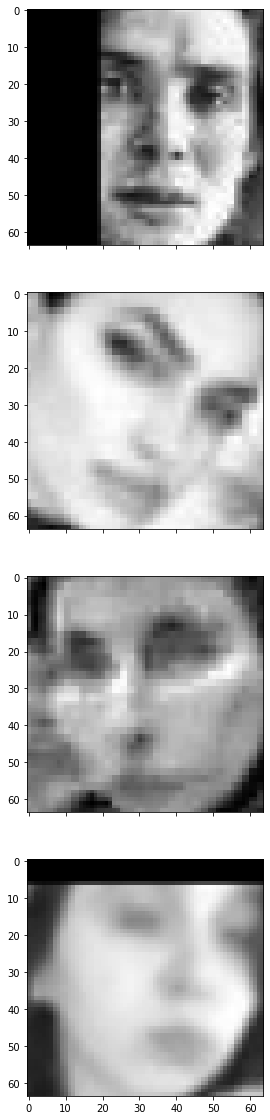

In [70]:
fig, ax = plt.subplots(4, figsize=(20, 20), sharex=True, sharey=True)

for i in range(4):
    ax[i].imshow(x_test_dlib_np[i], cmap=plt.cm.gray)

IndexError: index 4 is out of bounds for axis 0 with size 4

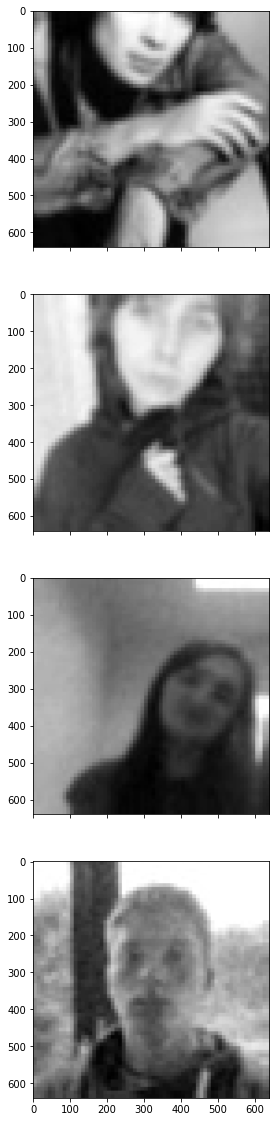

In [39]:
fig, ax = plt.subplots(4, figsize=(20, 20), sharex=True, sharey=True)

for i in range(5, 10):
    ax[i - 5].imshow(x_test_dlib_fails_np[i], cmap=plt.cm.gray)

# Model SVM for Haar

In [ ]:
test_hog_haar = HogImgs(x_test_dlib_np)

testing_hog_haar = np.asarray([i[0] for i in test_hog_haar])

pred_lr0 = model_svm_haar.predict(testing_hog_haar)

# Model SVM for Dlib

In [98]:
test_hog_haar = HogImgs(x_test_dlib_np)

testing_hog_haar = np.asarray([i[0] for i in test_hog_haar])

pred_lr = model_svm_haar.predict(testing_hog_haar)

100%|██████████| 4044/4044 [00:00<00:00, 11790.67it/s]


# Model SVM for Fails

In [99]:
test_fails_hog = HogImgs(x_test_dlib_fails_np)

testing_fails_hog = np.asarray([i[0] for i in test_fails_hog])

pred_lr2 = model_svm_fails.predict(testing_fails_hog)

100%|██████████| 106/106 [00:00<00:00, 1724.45it/s]


In [78]:
print(y_test_fails_dlib)

['img42.jpg', 'img480.jpg', 'img501.jpg', 'img1156.jpg', 'img1235.jpg', 'img1384.jpg', 'img1425.jpg', 'img1468.jpg', 'img1898.jpg', 'img2016.jpg', 'img2342.jpg', 'img2398.jpg', 'img2616.jpg', 'img2635.jpg', 'img2738.jpg', 'img2783.jpg', 'img2795.jpg', 'img2796.jpg', 'img3031.jpg', 'img3077.jpg', 'img3391.jpg', 'img3442.jpg', 'img3663.jpg', 'img3705.jpg']


# Сombining datasets

In [100]:
comb_data_imgs = np.concatenate([test_y, test_fails_y])
comb_data_labels = np.concatenate([pred_lr, pred_lr2])

print(comb_data_imgs[0], comb_data_labels[0])

img0.jpg 7


In [101]:
comb_data = sorted(zip(comb_data_imgs, comb_data_labels), key=lambda x: int(x[0].split('.')[0].split('img')[1]))
comb_data[:15]

[('img0.jpg', 7),
 ('img1.jpg', 17),
 ('img2.jpg', 17),
 ('img3.jpg', 13),
 ('img4.jpg', 16),
 ('img5.jpg', 1),
 ('img6.jpg', 10),
 ('img7.jpg', 5),
 ('img8.jpg', 11),
 ('img9.jpg', 13),
 ('img10.jpg', 1),
 ('img11.jpg', 11),
 ('img12.jpg', 4),
 ('img13.jpg', 14),
 ('img14.jpg', 20)]

In [82]:
import pandas as pd

In [83]:
pred_df = pd.DataFrame(comb_data, columns=['img', 'label'])
pred_df.head(15)

,img,label
0,img0.jpg,7
1,img1.jpg,17
2,img2.jpg,17
3,img3.jpg,13
4,img4.jpg,16
5,img5.jpg,1
6,img6.jpg,10
7,img7.jpg,15
8,img8.jpg,20
9,img9.jpg,13


In [102]:
pred_df.to_csv("last_dlib", index=False)